# TFM modelos predictivos arbol de decision y bosque aleatorio.

Antes de generar los modelos se deben procesar los datos para garantizar que estos esten limpios y no tengan datos faltantes.
Tambien se dividen los datos en dos clusters con KMeans, esto, para poder entrenar los modelos de clasificacion supervisados.

## Importar librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

## Cargar los datos desde el archivo Excel

Tambien se podran cargar los datos generados por el simulador de datos creado en [tfm_data_simulator](https://github.com/bigintelligence/tfm_data_simulator)

In [2]:
data = pd.read_excel('base_datos_sinteticChatGPT.xlsx')
data.describe()

,numerousuario,fitness,moda,viajes,cocina,belleza,decoracionhogar,tecnologia,familia,arte,motivacion,CES-D
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,150.500000,48.893333,63.086667,49.620000,49.353333,62.951733,46.770000,48.453333,50.613333,50.053333,48.036667,41.486667
std,86.746758,30.067182,20.403107,29.300124,29.178412,22.933359,29.553032,28.745356,29.133136,29.465310,28.820665,13.605398
min,1.000000,0.000000,30.000000,0.000000,0.000000,8.867727,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
25%,75.750000,22.750000,45.000000,23.750000,24.000000,45.245532,21.750000,25.000000,24.750000,24.750000,23.750000,30.000000
50%,150.500000,51.000000,62.500000,48.000000,50.000000,61.384166,46.000000,47.500000,52.000000,50.000000,46.000000,41.000000
75%,225.250000,74.000000,81.000000,74.000000,74.000000,82.293038,71.000000,73.000000,76.000000,76.000000,73.250000,54.000000
max,300.000000,99.000000,99.000000,99.000000,99.000000,116.147123,99.000000,99.000000,99.000000,99.000000,99.000000,60.000000


In [3]:
data.dtypes

numerousuario      float64
fitness            float64
moda               float64
viajes             float64
cocina             float64
belleza            float64
decoracionhogar    float64
tecnologia         float64
familia            float64
arte               float64
motivacion         float64
CES-D              float64
dtype: object

### Separar las características y la variable objetivo, excluyendo la columna 'numerousuario'

In [4]:
X = data.drop(columns=['numerousuario', 'CES-D'])  # Ajuste aquí para eliminar la columna 'numerousuario'
y = data['CES-D']

## Manejar los valores faltantes usando SimpleImputer

In [5]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [6]:
X_imputed.shape

(300, 10)

## Estandarizar las características

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

## Analisis de componentes PCA

In [8]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['CES-D'] = y

### Visualización de los componentes principales

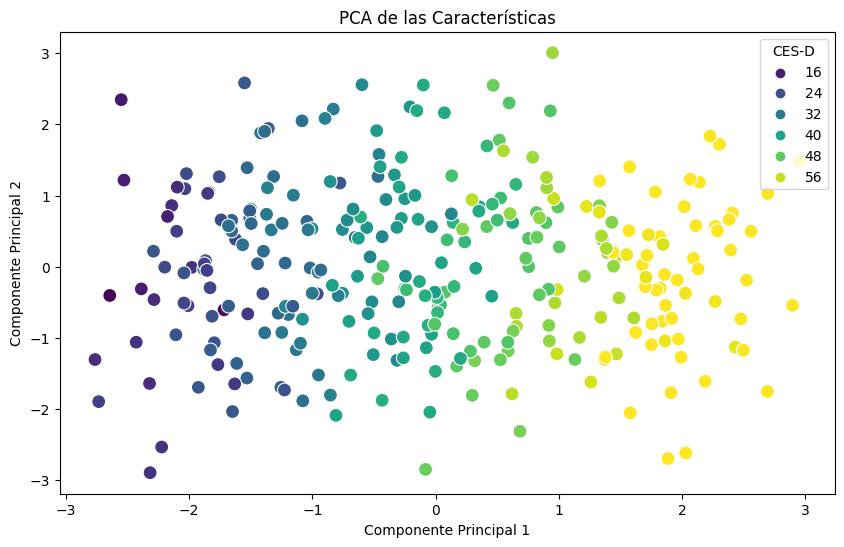

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='CES-D', data=pca_df, palette='viridis', s=100)
plt.title('PCA de las Características')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

### Visualización de la varianza explicada por cada componente principal

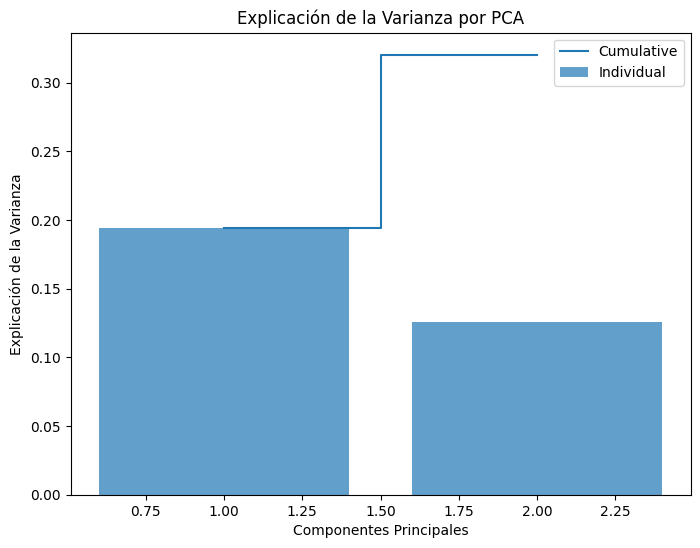

In [10]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Cumulative')
plt.ylabel('Explicación de la Varianza')
plt.xlabel('Componentes Principales')
plt.title('Explicación de la Varianza por PCA')
plt.legend(loc='best')
plt.show()


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.patches import Ellipse

## Aplicar KMeans

### Añadir las etiquetas de los usuarios

In [12]:
pca_df['numerousuario'] = data['numerousuario']

In [13]:
pca_df.describe()

,PC1,PC2,CES-D,numerousuario
count,3.000000e+02,3.000000e+02,300.000000,300.000000
mean,2.960595e-17,-2.960595e-18,41.486667,150.500000
std,1.396191e+00,1.124985e+00,13.605398,86.746758
min,-2.763482e+00,-2.893905e+00,12.000000,1.000000
25%,-1.167076e+00,-8.110687e-01,30.000000,75.750000
50%,-3.923021e-02,-2.905444e-03,41.000000,150.500000
75%,1.140362e+00,7.480565e-01,54.000000,225.250000
max,2.953926e+00,3.006795e+00,60.000000,300.000000


### Método del codo para encontrar el número óptimo de clusters

In [14]:
inertia = []
silhouette_scores = []
range_n_clusters = list(range(2, 11))
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, clusters))

### Graficar el Método del codo

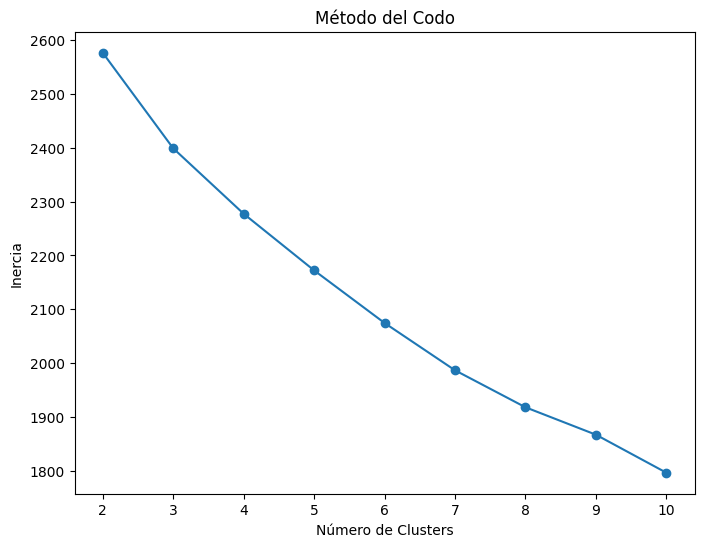

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

### Graficar el Silhouette Score

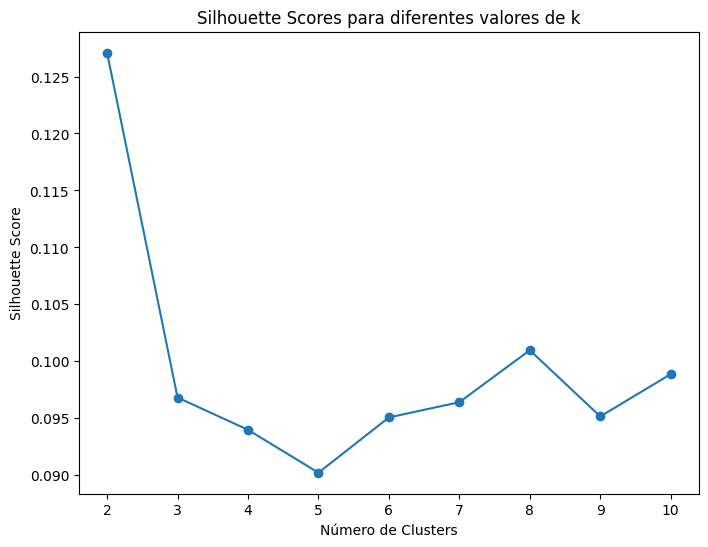

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores para diferentes valores de k')
plt.show()

Elegir el mejor k basado en el Silhouette Score

In [17]:
best_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f'Mejor número de clusters basado en el Silhouette Score: {best_k}')

Mejor número de clusters basado en el Silhouette Score: 2


Aplicar K-means clustering con el mejor número de clusters

In [18]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
pca_df['Cluster'] = clusters

### Visualización de los componentes principales con elipses alrededor de los grupos

Función para dibujar elipses alrededor de los grupos

In [19]:
def draw_ellipse(position, covariance, ax, **kwargs):
    """Dibuja una elipse con la posición y covarianza dadas"""
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

C:\Users\dante\AppData\Local\Temp\ipykernel_11820\661810294.py:11: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


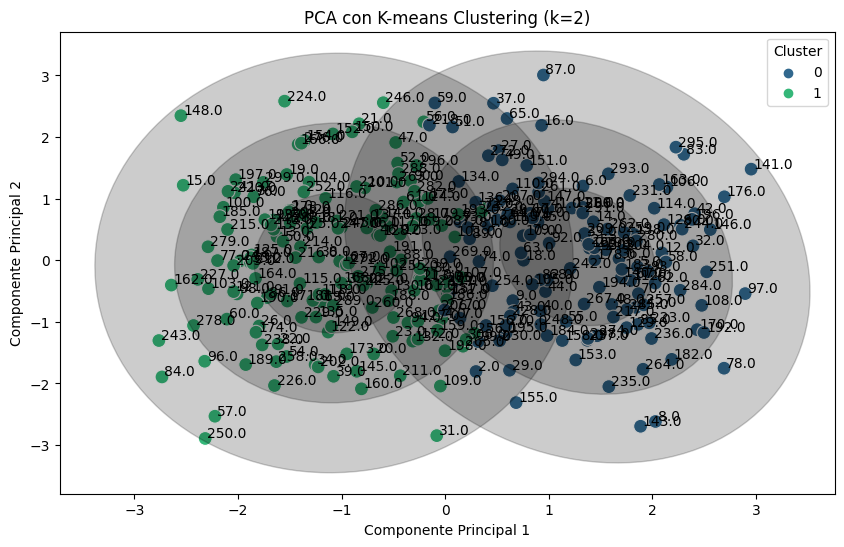

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100)
plt.title('PCA con K-means Clustering (k=2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
# Añadir etiquetas a los puntos
for i, point in pca_df.iterrows():
    plt.text(point['PC1']+0.02, point['PC2']+0.02, str(point['numerousuario']), horizontalalignment='left', size='medium', color='black')

for cluster in np.unique(clusters):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    if len(cluster_data) > 1:
        covariance = np.cov(cluster_data[['PC1', 'PC2']], rowvar=False)
        draw_ellipse(cluster_data[['PC1', 'PC2']].mean(), covariance, plt.gca(), alpha=0.2, color='black')
plt.show()

Crear listas de muestras por cluster

In [21]:
clusters_dict = {}
for cluster in np.unique(clusters):
    clusters_dict[cluster] = pca_df[pca_df['Cluster'] == cluster]['numerousuario'].tolist()

Imprimir la lista de muestras por cluster

In [22]:
for cluster, samples in clusters_dict.items():
    print(f"Cluster {cluster}: {samples}")


Cluster 0: [2.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0, 14.0, 16.0, 17.0, 18.0, 27.0, 29.0, 32.0, 33.0, 36.0, 37.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 48.0, 49.0, 51.0, 55.0, 58.0, 59.0, 62.0, 63.0, 64.0, 65.0, 67.0, 68.0, 70.0, 71.0, 73.0, 74.0, 75.0, 78.0, 79.0, 80.0, 82.0, 83.0, 85.0, 87.0, 89.0, 92.0, 93.0, 95.0, 97.0, 99.0, 105.0, 106.0, 108.0, 110.0, 111.0, 112.0, 113.0, 114.0, 126.0, 129.0, 134.0, 136.0, 138.0, 140.0, 141.0, 142.0, 143.0, 146.0, 147.0, 151.0, 153.0, 155.0, 156.0, 157.0, 158.0, 163.0, 165.0, 170.0, 176.0, 178.0, 180.0, 182.0, 183.0, 184.0, 192.0, 194.0, 195.0, 196.0, 203.0, 204.0, 207.0, 209.0, 217.0, 218.0, 219.0, 223.0, 228.0, 230.0, 231.0, 234.0, 235.0, 236.0, 237.0, 242.0, 244.0, 248.0, 249.0, 251.0, 253.0, 254.0, 257.0, 259.0, 261.0, 262.0, 264.0, 266.0, 267.0, 269.0, 270.0, 272.0, 274.0, 277.0, 280.0, 281.0, 284.0, 285.0, 290.0, 291.0, 293.0, 294.0, 295.0, 297.0, 298.0]
Cluster 1: [1.0, 3.0, 4.0, 11.0, 13.0, 15.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26

In [23]:
# Crear una nueva DataFrame con las muestras y sus clusters
clustered_data = data[['numerousuario', 'CES-D']].copy()
clustered_data['Cluster'] = clusters

# Exportar a un archivo Excel
clustered_data.to_excel('clustered_data_k2.xlsx', index=False)
print("El archivo Excel ha sido guardado como 'clustered_data_k2.xlsx' en la ruta especificada.")

El archivo Excel ha sido guardado como 'clustered_data_k2.xlsx' en la ruta especificada.


## Agregar a data la columna Cluster obtenida con KMeans

In [24]:
clustered_data.describe()

,numerousuario,CES-D,Cluster
count,300.000000,300.000000,300.000000
mean,150.500000,41.486667,0.543333
std,86.746758,13.605398,0.498951
min,1.000000,12.000000,0.000000
25%,75.750000,30.000000,0.000000
50%,150.500000,41.000000,1.000000
75%,225.250000,54.000000,1.000000
max,300.000000,60.000000,1.000000


In [25]:
data_cluster_merged = pd.merge(data, clustered_data, on=['numerousuario','numerousuario']).drop(columns=['CES-D_x','CES-D_y'])
data_cluster_merged.describe()

,numerousuario,fitness,moda,viajes,cocina,belleza,decoracionhogar,tecnologia,familia,arte,motivacion,Cluster
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,150.500000,48.893333,63.086667,49.620000,49.353333,62.951733,46.770000,48.453333,50.613333,50.053333,48.036667,0.543333
std,86.746758,30.067182,20.403107,29.300124,29.178412,22.933359,29.553032,28.745356,29.133136,29.465310,28.820665,0.498951
min,1.000000,0.000000,30.000000,0.000000,0.000000,8.867727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.750000,22.750000,45.000000,23.750000,24.000000,45.245532,21.750000,25.000000,24.750000,24.750000,23.750000,0.000000
50%,150.500000,51.000000,62.500000,48.000000,50.000000,61.384166,46.000000,47.500000,52.000000,50.000000,46.000000,1.000000
75%,225.250000,74.000000,81.000000,74.000000,74.000000,82.293038,71.000000,73.000000,76.000000,76.000000,73.250000,1.000000
max,300.000000,99.000000,99.000000,99.000000,99.000000,116.147123,99.000000,99.000000,99.000000,99.000000,99.000000,1.000000


## Crear y entrenar un modelo de Decision Tree

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Dividir los datos en conjuntos de entrenamiento y prueba

In [27]:
y=data_cluster_merged['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

crear el modelo

In [28]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Predecir y calcular la precisión del modelo de Decision Tree

In [29]:
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f'Precisión del Decision Tree: {dt_accuracy:.2f}')

Precisión del Decision Tree: 0.96


Matriz de confusión para Decision Tree

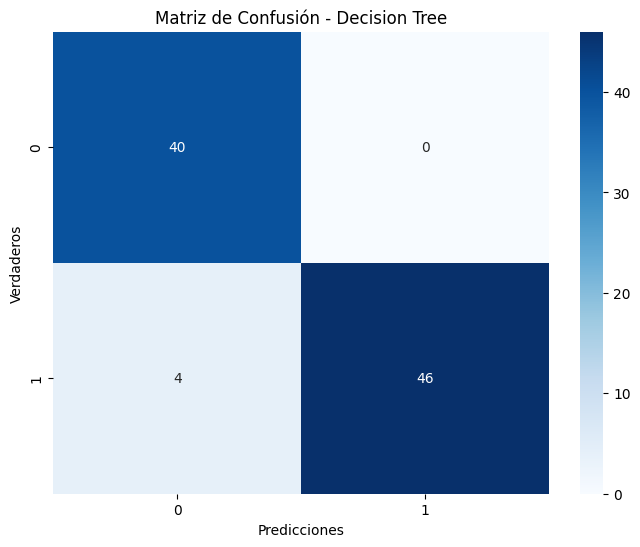

In [30]:
dt_cm = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Decision Tree')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

### Reporte de clasificación para Decision Tree

In [31]:
print('Reporte de Clasificación - Decision Tree')
print(classification_report(y_test, dt_predictions))

Reporte de Clasificación - Decision Tree
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        40
           1       1.00      0.92      0.96        50

    accuracy                           0.96        90
   macro avg       0.95      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



### Visualización del árbol de decisión

In [32]:
dt_model

DecisionTreeClassifier(random_state=42)

In [33]:
dt_predictions.shape

(90,)

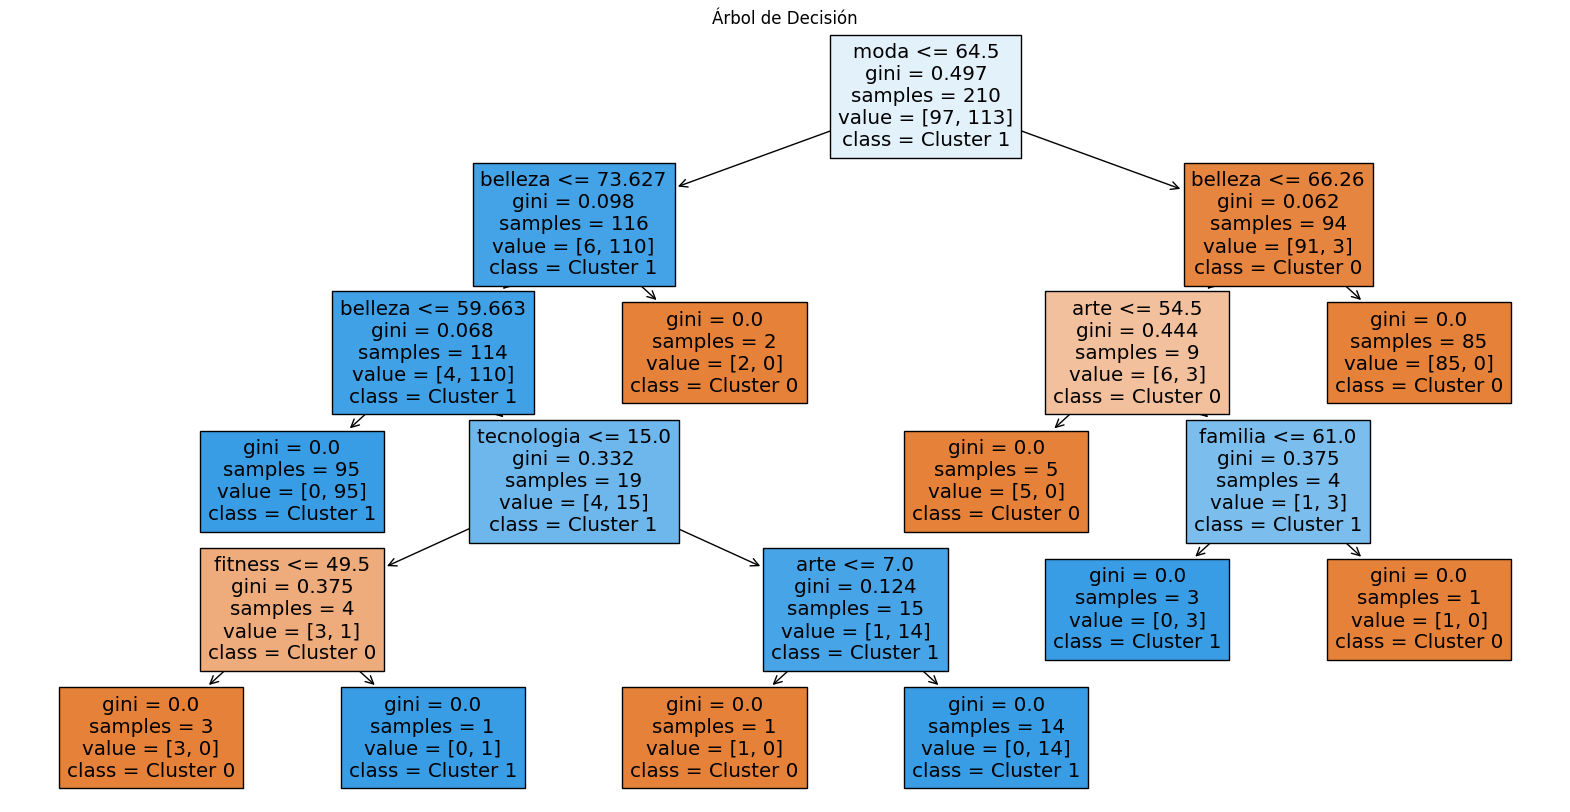

In [34]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=data_cluster_merged.drop(columns=['numerousuario', 'Cluster']).columns,class_names=['Cluster 0', 'Cluster 1'])
plt.title('Árbol de Decisión')
plt.show()

## Crear y entrenar un modelo de Random Forest supervisado

In [35]:
from sklearn.ensemble import RandomForestClassifier

se reutilizan los datos de entrenamiento y prueba del arbol de decision

In [36]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Predecir y calcular la precisión del modelo de Random Forest

In [37]:
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Precisión del Random Forest: {rf_accuracy:.2f}')

Precisión del Random Forest: 0.97


### Matriz de confusión para Random Forest

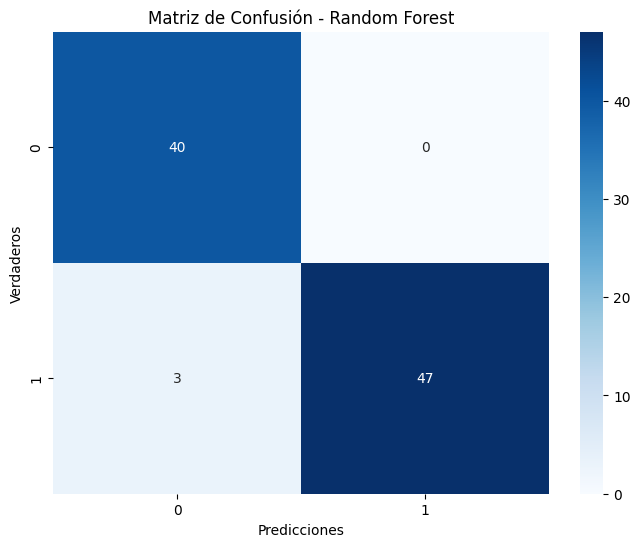

In [38]:
rf_cm = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

### Reporte de clasificación para Random Forest

In [39]:
print('Reporte de Clasificación - Random Forest')
print(classification_report(y_test, rf_predictions))

Reporte de Clasificación - Random Forest
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       1.00      0.94      0.97        50

    accuracy                           0.97        90
   macro avg       0.97      0.97      0.97        90
weighted avg       0.97      0.97      0.97        90



### Importancia de características para Random Forest

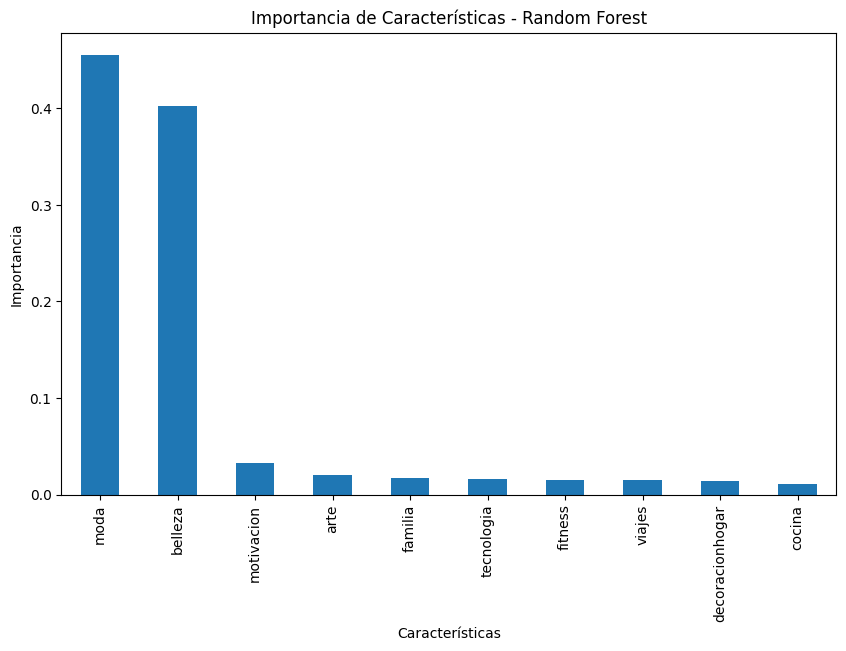

In [40]:
importances = rf_model.feature_importances_
indices = pd.Series(importances, index=data_cluster_merged.drop(columns=['numerousuario', 'Cluster']).columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
indices.plot(kind='bar')
plt.title('Importancia de Características - Random Forest')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.show()

## Reporte de clasificación para ambos modelos

In [41]:
print('Reporte de Clasificación - Decision Tree')
print(classification_report(y_test, dt_predictions))

print('Reporte de Clasificación - Random Forest')
print(classification_report(y_test, rf_predictions))

Reporte de Clasificación - Decision Tree
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        40
           1       1.00      0.92      0.96        50

    accuracy                           0.96        90
   macro avg       0.95      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90

Reporte de Clasificación - Random Forest
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        40
           1       1.00      0.94      0.97        50

    accuracy                           0.97        90
   macro avg       0.97      0.97      0.97        90
weighted avg       0.97      0.97      0.97        90

